# Dodanie ścieżki do projektu

In [33]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Importowanie bibliotek

In [34]:
from src.scrapers import healthdata, koronawirusunas, meteostat, policjapl, rmf24, wiki_demo, wiki_urban
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from src.utils import save, paths
from pathlib import Path
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn import cluster
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Pobranie i zapisanie danych

In [35]:
update = True

if len(os.listdir(paths.get_path())) == 0 or update:
    data = {**healthdata.get_data(),
            **koronawirusunas.get_data(),
            **{"meteostat": pd.DataFrame(meteostat.get_data(end_date=str(datetime.datetime.now().date()), start_date="2020-01-01"))},
            **policjapl.scrape(),
            **wiki_demo.get_data(),
            **wiki_urban.get_data()
           }
    save.save_dataframes(data=data)
else:
    print("Data directory is not empty. propably data inside.")

ConnectionResetError error. Trying again... 
ConnectionResetError error. Trying again... 
/home/piotrk/.local/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


# Załadowanie danych

In [37]:
policja = pd.read_csv(Path(paths.get_path(), "policjapl.csv"), index_col=1, parse_dates=True, dayfirst=True)
health = pd.read_csv(Path(paths.get_path(), "healthdata.csv"), index_col=2, parse_dates=True, dayfirst=True)
korona = pd.read_csv(Path(paths.get_path(), "koronawirusunas.csv"), index_col=0, parse_dates=True, dayfirst=True)
meteo = pd.read_csv(Path(paths.get_path(), "meteostat.csv"), index_col=1, parse_dates=True, dayfirst=True)
urban = pd.read_csv(Path(paths.get_path(), "urbanizacja.csv"), index_col=0, parse_dates=True, dayfirst=True)
demografia = pd.read_csv(Path(paths.get_path(), "demografia.csv"), index_col=0, parse_dates=True, dayfirst=True)

In [38]:
woj = koronawirusunas.SUB_SITES
wojewodztwa = pd.DataFrame()
v2 = pd.DataFrame()
w["wojewodztwo"] = np.nan
for i in range(1, len(woj)):
    dat = pd.read_csv(Path(paths.get_path(), woj[i][12:] + ".csv"), index_col=0, parse_dates=True, dayfirst=True)
    dat.fillna(axis=1, inplace=True, value=0)
    dat["wojewodztwo"] = np.nan
    dat.fillna(axis=1, inplace=True, value=woj[i][12:])
    wojewodztwa = wojewodztwa.append(dat)

# Czyszczenie danych

## Czyszczenie meteo

In [5]:
meteo.head()

,Unnamed: 0,temperature,temperature_min,temperature_max,precipitation,snowfall,snowdepth,winddirection,windspeed,peakgust,sunshine,pressure
date,,,,,,,,,,,,
2020-01-01,0,1.4,0.8,5.6,1.0,NaN,NaN,267.0,17.4,NaN,NaN,1029.3
2020-01-02,1,0.8,-1.7,3.1,NaN,NaN,NaN,NaN,13.8,NaN,NaN,1026.5
2020-01-03,2,0.5,-4.1,4.6,NaN,NaN,NaN,205.0,6.4,NaN,NaN,1020.1
2020-01-04,3,3.7,1.6,5.3,1.0,NaN,NaN,258.0,20.7,NaN,NaN,1012.3
2020-01-05,4,0.4,-2.4,2.3,1.8,NaN,NaN,283.0,17.9,NaN,NaN,1025.8


In [6]:
meteo.drop(["snowfall", "snowdepth", "peakgust", "sunshine","precipitation","Unnamed: 0"], axis=1, inplace=True)
meteo.index.name = None
meteo.head()

,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure
2020-01-01,1.4,0.8,5.6,267.0,17.4,1029.3
2020-01-02,0.8,-1.7,3.1,NaN,13.8,1026.5
2020-01-03,0.5,-4.1,4.6,205.0,6.4,1020.1
2020-01-04,3.7,1.6,5.3,258.0,20.7,1012.3
2020-01-05,0.4,-2.4,2.3,283.0,17.9,1025.8


In [7]:
meteo[meteo.isnull().any(axis=1)]

,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure
2020-01-02,0.8,-1.7,3.1,NaN,13.8,1026.5
2020-01-13,4.8,2.0,NaN,NaN,NaN,NaN
2020-05-03,10.4,6.0,14.2,NaN,11.4,1011.8


In [8]:
meteo['winddirection'].fillna(meteo['winddirection'].mean(), inplace = True)
meteo['temperature_max'].fillna(meteo['temperature_max'].mean(), inplace = True)
meteo['pressure'].fillna(meteo['pressure'].mean(), inplace = True)
meteo['windspeed'].fillna(meteo['windspeed'].mean(), inplace = True)

In [9]:
meteo[meteo.isnull().any(axis=1)]

,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure


## Czyszczenie health

In [10]:
health.columns

Index(['V1', 'location_name', 'allbed_mean', 'allbed_lower', 'allbed_upper',
       'ICUbed_mean', 'ICUbed_lower', 'ICUbed_upper', 'InvVen_mean',
       'InvVen_lower', 'InvVen_upper', 'deaths_mean', 'deaths_lower',
       'deaths_upper', 'admis_mean', 'admis_lower', 'admis_upper',
       'newICU_mean', 'newICU_lower', 'newICU_upper', 'totdea_mean',
       'totdea_lower', 'totdea_upper', 'bedover_mean', 'bedover_lower',
       'bedover_upper', 'icuover_mean', 'icuover_lower', 'icuover_upper',
       'deaths_mean_smoothed', 'deaths_lower_smoothed',
       'deaths_upper_smoothed', 'totdea_mean_smoothed',
       'totdea_lower_smoothed', 'totdea_upper_smoothed', 'mobility_data_type',
       'mobility_composite', 'total_tests_data_type', 'total_tests',
       'confirmed_infections', 'est_infections_mean', 'est_infections_lower',
       'est_infections_upper'],
      dtype='object')

In [11]:
health = health.drop(health[health.index > "2020-05-20"].index)
health = health[health.location_name == "Poland"]
health = health[["allbed_mean", "ICUbed_mean", "deaths_mean", "admis_mean", "newICU_mean", 
                 "totdea_mean", "bedover_mean", "icuover_mean", 
                 "mobility_composite", "total_tests", "confirmed_infections"]]
health.index.name = None

In [12]:
health.tail()

,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections
2020-05-16,434.829267,136.513487,8.0,46.936025,14.164300,915.0,0.0,0.0,-29.270980,19742.765892,322.594580
2020-05-17,409.154800,130.489962,10.0,46.770750,14.418250,925.0,0.0,0.0,-29.275501,19953.899272,322.593956
2020-05-18,397.374917,128.283183,11.0,49.147754,14.964267,936.0,0.0,0.0,-29.306475,20124.802374,345.489340
2020-05-19,393.730192,126.842613,12.0,47.749646,14.441683,948.0,0.0,0.0,-29.355494,20262.868461,383.297532
2020-05-20,389.284775,124.126312,14.0,45.355958,13.882433,962.0,0.0,0.0,-29.355494,20374.591746,410.496531


In [13]:
health[health.isnull().any(axis=1)]

,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections
2019-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2019-12-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.680087,NaN,NaN
2020-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.429874,NaN,NaN
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.156718,NaN,NaN
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.800878,NaN,NaN


In [14]:
health.fillna(0, inplace = True)

In [15]:
health[health.isnull().any(axis=1)]

,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections


## Czyszczenie policja

In [18]:
policja.head()

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach
2020-05-25,15489,546,250,178,57,6,71
2020-05-24,13749,630,166,284,50,10,66
2020-05-23,16946,625,180,242,50,5,57
2020-05-22,17807,622,269,188,72,2,82
2020-05-21,16706,640,306,201,72,6,71


In [19]:
policja.index.name = None
policja.head()

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach
2020-05-25,15489,546,250,178,57,6,71
2020-05-24,13749,630,166,284,50,10,66
2020-05-23,16946,625,180,242,50,5,57
2020-05-22,17807,622,269,188,72,2,82
2020-05-21,16706,640,306,201,72,6,71


In [20]:
policja[policja.isnull().any(axis=1)]

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach


## Czyszczenie korona

In [21]:
korona.head()

,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.53,4.70,NaN,NaN,NaN,NaN
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.05,6.90,NaN,NaN,NaN,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.24,4.46,NaN,NaN,NaN,NaN
2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.95,7.81,NaN,NaN,NaN,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.57,22.21,NaN,NaN,NaN,NaN


In [22]:
korona.tail()

,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-05-22,20619.0,719571.0,660800.0,20619.0,10906.0,982.0,8731.0,-22.0,-0.67,2261.0,77768.0,NaN,19500.0
2020-05-23,20931.0,750939.0,687080.0,20931.0,10961.0,993.0,8977.0,NaN,NaN,2271.0,80635.0,NaN,19836.0
2020-05-24,21326.0,767441.0,701969.0,21326.0,11136.0,996.0,9194.0,NaN,NaN,2242.0,79326.0,NaN,19529.0
2020-05-25,21631.0,779576.0,712675.0,21631.0,11348.0,1007.0,9276.0,NaN,NaN,2268.0,78259.0,NaN,19587.0
2020-05-26,NaN,NaN,NaN,21867.0,10834.0,1013.0,10020.0,NaN,NaN,2171.0,78864.0,NaN,19139.0


### Wypełnienie nan

In [23]:
korona['kwar_z'].fillna(0, inplace=True)
korona.fillna(method='ffill', inplace=True)
korona.fillna(0, inplace=True)
korona

,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.53,4.70,0.0,0.0,0.0,0.0
2020-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.05,6.90,0.0,0.0,0.0,0.0
2020-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.24,4.46,0.0,0.0,0.0,0.0
2020-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.95,7.81,0.0,0.0,0.0,0.0
2020-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.57,22.21,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22,20619.0,719571.0,660800.0,20619.0,10906.0,982.0,8731.0,-22.00,-0.67,2261.0,77768.0,0.0,19500.0
2020-05-23,20931.0,750939.0,687080.0,20931.0,10961.0,993.0,8977.0,-22.00,-0.67,2271.0,80635.0,0.0,19836.0
2020-05-24,21326.0,767441.0,701969.0,21326.0,11136.0,996.0,9194.0,-22.00,-0.67,2242.0,79326.0,0.0,19529.0
2020-05-25,21631.0,779576.0,712675.0,21631.0,11348.0,1007.0,9276.0,-22.00,-0.67,2268.0,78259.0,0.0,19587.0


In [24]:
korona[korona.isnull().any(axis=1)]

,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor


##  Czyszczenie urbanizacja

In [40]:
urban[urban.isnull().any(axis=1)]

,TERYT,Województwo,Miasta – siedziby województw,"Powierzchnia[km²], 31.12.2018[3]",Ludność(31 XII 2018)[4],Gęstość zaludnienia (osób/km²),Poziomurbanizacji(31 XII 2018),Stopa bezrobocia(I 2019)[5],PKB na 1 mieszkańca(31 XII 2018) [zł][3],Wyróżnik województwa na tablicachrejestracyjnych


In [42]:
urban = urban.drop(columns=["TERYT", "Miasta – siedziby województw","Wyróżnik województwa na tablicachrejestracyjnych"])

In [43]:
urban

,Województwo,"Powierzchnia[km²], 31.12.2018[3]",Ludność(31 XII 2018)[4],Gęstość zaludnienia (osób/km²),Poziomurbanizacji(31 XII 2018),Stopa bezrobocia(I 2019)[5],PKB na 1 mieszkańca(31 XII 2018) [zł][3]
0,dolnośląskie,19 947,2 901 225,14545,"68,61%","5,4%",57 228
1,kujawsko-pomorskie,17 972,2 077 775,11562,"59,09%","9,2%",41 875
2,lubelskie,25 122,2 117 629,8429,"46,46%","8,4%",35 712
3,lubuskie,13 988,1 014 548,7253,"64,95%","6,2%",42 755
4,łódzkie,18 219,2 466 322,13537,"62,55%","6,3%",48 126
5,małopolskie,15 183,3 400 577,22398,"48,19%","4,9%",47 272
6,mazowieckie,35 558,5 403 412,15196,"64,40%","5,1%",83 123
7,opolskie,9412,986 506,10482,"53,30%","6,6%",41 080
8,podkarpackie,17 846,2 129 015,11930,"41,09%","9,1%",36 088
9,podlaskie,20 187,1 181 533,5853,"60,79%","8,1%",37 077


In [59]:
urban.rename(columns={
    "Województwo": "wojowodztwo",
    "Powierzchnia[km²], 31.12.2018[3]": "powierzchnina",
    "Ludność(31 XII 2018)[4]": "ludnosc",
    "Gęstość zaludnienia (osób/km²)": "gestosc_zal",
    "Poziomurbanizacji(31 XII 2018)": "urbanizacja",
    "Stopa bezrobocia(I\xa02019)[5]": "stopa_bezrobocia",
    "PKB na 1 mieszkańca(31 XII 2018) [zł][3]": "pdb_na_miesz"
}, inplace=True)


In [60]:
urban.columns

Index(['wojowodztwo', 'powierzchnina', 'ludnosc', 'gestosc_zal', 'urbanizacja',
       'stopa_bezrobocia', 'pdb_na_miesz'],
      dtype='object')

## Łączenie danych

In [25]:
df = pd.merge(policja, meteo, how='outer', left_index=True, right_index=True)
df = pd.merge(df, health, how='outer', left_index=True, right_index=True)
df = pd.merge(df, korona, how='outer', left_index=True, right_index=True)

In [26]:
df.iloc[0]

Interwencje                        NaN
Zatrzymani na gorącym uczynku      NaN
Zatrzymani poszukiwani             NaN
Zatrzymani nietrzeźwi kierujący    NaN
Wypadki drogowe                    NaN
Zabici w wypadkach                 NaN
Ranni w wypadkach                  NaN
temperature                        NaN
temperature_min                    NaN
temperature_max                    NaN
winddirection                      NaN
windspeed                          NaN
pressure                           NaN
allbed_mean                        0.0
ICUbed_mean                        0.0
deaths_mean                        0.0
admis_mean                         0.0
newICU_mean                        0.0
totdea_mean                        0.0
bedover_mean                       0.0
icuover_mean                       0.0
mobility_composite                 0.0
total_tests                        0.0
confirmed_infections               0.0
smp                                NaN
testy                    

## Czyszczenie df

In [27]:
df.fillna(method='ffill', inplace=True)
df.head()

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2019-12-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Usunięcie danych sprzed 01.01.2020

In [28]:
df.drop(df[df.index < "2020-01-01"].index, inplace = True)
df

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-01-01,19145.0,734.0,188.0,332.0,42.0,1.0,46.0,1.4,0.8,5.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,14654.0,513.0,333.0,166.0,60.0,5.0,67.0,0.8,-1.7,3.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,15507.0,468.0,405.0,122.0,62.0,3.0,69.0,0.5,-4.1,4.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,14528.0,435.0,176.0,135.0,59.0,4.0,64.0,3.7,1.6,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,11948.0,457.0,185.0,146.0,44.0,4.0,54.0,0.4,-2.4,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22,17807.0,622.0,269.0,188.0,72.0,2.0,82.0,10.3,2.0,17.0,...,20619.0,10906.0,982.0,8731.0,-22.0,-0.67,2261.0,77768.0,0.0,19500.0
2020-05-23,16946.0,625.0,180.0,242.0,50.0,5.0,57.0,12.6,4.0,18.0,...,20931.0,10961.0,993.0,8977.0,-22.0,-0.67,2271.0,80635.0,0.0,19836.0
2020-05-24,13749.0,630.0,166.0,284.0,50.0,10.0,66.0,13.0,8.0,19.0,...,21326.0,11136.0,996.0,9194.0,-22.0,-0.67,2242.0,79326.0,0.0,19529.0
2020-05-25,15489.0,546.0,250.0,178.0,57.0,6.0,71.0,12.2,8.0,18.0,...,21631.0,11348.0,1007.0,9276.0,-22.0,-0.67,2268.0,78259.0,0.0,19587.0


In [29]:
df[df.isnull().any(axis=1)].head()

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
2020-01-01,19145.0,734.0,188.0,332.0,42.0,1.0,46.0,1.4,0.8,5.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,14654.0,513.0,333.0,166.0,60.0,5.0,67.0,0.8,-1.7,3.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,15507.0,468.0,405.0,122.0,62.0,3.0,69.0,0.5,-4.1,4.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,14528.0,435.0,176.0,135.0,59.0,4.0,64.0,3.7,1.6,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,11948.0,457.0,185.0,146.0,44.0,4.0,54.0,0.4,-2.4,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df.fillna(0,inplace=True)
df[df.isnull().any(axis=1)].head()

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor


## Dodanie kolumny z datą od rozpoczęcia ( potrzebna do regresji )

In [31]:
df["date"] = (df.index - df.index.min())  / np.timedelta64(1,'D')

# Współcznniki korelacji

In [32]:
def highlight(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    l = []
    for v in s:
        if abs(v) > 0.85 and abs(v) != 1:
            l.append('background-color: red')
        elif abs(v) > 0.75 and abs(v) != 1:
            l.append('background-color: yellow')
        else: 
            l.append('')
    return l

## Pearson

In [35]:
cor_pearson = df.corr(method="pearson")
cor_pearson.style.apply(highlight)

cor_pearson = cor_pearson.where(np.triu(np.ones(cor_pearson.shape)).astype(np.bool))
cor_pearson = cor_pearson.stack().reset_index()
cor_pearson.columns = ['Row','Column','Value']
cor_pearson['Value'] = pd.to_numeric(cor_pearson['Value'])
to_check_prearson = cor_pearson[(abs(cor_pearson['Value']) >= 0.75) & (abs(cor_pearson['Value']) != 1)]

In [36]:
to_check_prearson.head(50)

,Row,Column,Value
65,Zatrzymani na gorącym uczynku,pojazdem,0.814156
69,Zatrzymani na gorącym uczynku,nadzor,-0.786475
140,Wypadki drogowe,Ranni w wypadkach,0.969319
164,Wypadki drogowe,pojazdem,0.759411
225,Ranni w wypadkach,pojazdem,0.778714
232,temperature,temperature_min,0.820213
233,temperature,temperature_max,0.965706
250,temperature,chor,0.769938
300,temperature_max,confirmed_infections,0.750689
305,temperature_max,chor,0.750160


## Kendall

In [30]:
cor_pearson = df.corr(method="kendall")
cor_pearson.style.apply(highlight)

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
Interwencje,1.000000,0.130961,-0.008897,0.217859,0.135521,0.082443,0.115208,0.336292,0.271884,0.313355,-0.055150,-0.118685,-0.009081,0.229582,0.216355,0.267758,0.250400,0.245100,0.233491,nan,nan,-0.108953,0.241262,0.198996,0.244053,0.244144,0.260575,0.244039,0.344351,0.234262,0.345091,-0.070604,-0.064084,0.226668,0.228551,-0.237994,0.132694
Zatrzymani na gorącym uczynku,0.130961,1.000000,0.353108,0.479386,0.426803,0.135708,0.424031,-0.024410,0.151887,-0.080145,0.033776,-0.070805,-0.179390,-0.313229,-0.304697,-0.260818,-0.330793,-0.343115,-0.167155,nan,nan,0.517060,-0.164348,-0.383470,-0.159899,-0.159785,0.206984,-0.159890,0.019881,-0.166253,0.024080,0.513096,0.519421,-0.269486,-0.401086,-0.382630,-0.520112
Zatrzymani poszukiwani,-0.008897,0.353108,1.000000,-0.090089,0.535372,0.028789,0.523133,-0.179279,-0.010744,-0.238032,0.052197,0.011203,-0.203316,-0.416196,-0.415788,-0.320073,-0.433527,-0.444897,-0.341123,nan,nan,0.524083,-0.330044,-0.406748,-0.337811,-0.337792,-0.060026,-0.337792,-0.188865,-0.341586,-0.192076,0.579974,0.607932,-0.379191,-0.485674,-0.352005,-0.576437
Zatrzymani nietrzeźwi kierujący,0.217859,0.479386,-0.090089,1.000000,0.112636,0.187289,0.125897,0.177818,0.218547,0.153304,0.020740,-0.096697,-0.107133,0.017829,0.024669,0.004486,-0.009403,-0.004488,0.080169,nan,nan,0.167676,0.084549,-0.058174,0.086474,0.086574,0.263064,0.086469,0.228709,0.081076,0.231433,0.156502,0.132771,0.021959,-0.065456,-0.278621,-0.159385
Wypadki drogowe,0.135521,0.426803,0.535372,0.112636,1.000000,0.218857,0.861406,-0.058790,0.101498,-0.129594,0.003820,-0.055023,-0.244894,-0.354149,-0.353398,-0.332742,-0.382179,-0.390588,-0.287732,nan,nan,0.490061,-0.261942,-0.397062,-0.265231,-0.265321,0.034074,-0.265215,-0.127764,-0.287483,-0.129255,0.559734,0.559324,-0.317098,-0.456719,-0.324811,-0.520835
Zabici w wypadkach,0.082443,0.135708,0.028789,0.187289,0.218857,1.000000,0.186326,0.008415,0.063763,-0.032552,0.025919,0.081792,-0.103900,-0.069739,-0.065379,-0.090837,-0.082312,-0.080025,-0.082272,nan,nan,0.111646,-0.073617,-0.066169,-0.067309,-0.067416,-0.005585,-0.067305,-0.040118,-0.081858,-0.040378,0.135248,0.122982,-0.061779,-0.113943,-0.033341,-0.124774
Ranni w wypadkach,0.115208,0.424031,0.523133,0.125897,0.861406,0.186326,1.000000,-0.096336,0.071921,-0.152877,-0.007351,-0.062936,-0.239403,-0.375490,-0.371423,-0.346392,-0.406815,-0.416549,-0.305649,nan,nan,0.523732,-0.275861,-0.402902,-0.281509,-0.281388,0.023410,-0.281493,-0.140780,-0.304839,-0.143017,0.576741,0.575304,-0.327460,-0.472951,-0.333629,-0.537051
temperature,0.336292,-0.024410,-0.179279,0.177818,-0.058790,0.008415,-0.096336,1.000000,0.629663,0.832500,-0.022638,-0.061754,-0.160662,0.513936,0.512488,0.498731,0.503220,0.495993,0.530857,nan,nan,-0.282511,0.545507,0.425073,0.542463,0.542326,0.436566,0.542431,0.570089,0.530940,0.572565,-0.252286,-0.277034,0.537179,0.433819,-0.060719,0.327518
temperature_min,0.271884,0.151887,-0.010744,0.218547,0.101498,0.063763,0.071921,0.629663,1.000000,0.505573,0.057777,0.007142,-0.259884,0.287967,0.293716,0.283991,0.279635,0.265439,0.334957,nan,nan,-0.086193,0.344959,0.200747,0.343644,0.343519,0.436556,0.343624,0.445496,0.333690,0.445991,-0.067133,-0.073274,0.327226,0.212019,-0.169426,0.083147
temperature_max,0.313355,-0.080145,-0.238032,0.153304,-0.129594,-0.032552,-0.152877,0.832500,0.505573,1.000000,-0.039654,-0.076008,-0.110974,0.553830,0.552182,0.534259,0.532593,0.536566,0.557333,nan,nan,-0.336571,0.572918,0.473552,0.570480,0.570342,0.413626,0.570447,0.556834,0.557609,0.557082,-0.316535,-0.339846,0.573

In [38]:
cor_pearson = df.corr(method="kendall")
cor_pearson.style.apply(highlight)

cor_pearson = cor_pearson.where(np.triu(np.ones(cor_pearson.shape)).astype(np.bool))
cor_pearson = cor_pearson.stack().reset_index()
cor_pearson.columns = ['Row','Column','Value']
cor_pearson['Value'] = pd.to_numeric(cor_pearson['Value'])
to_check_kendall = cor_pearson[(abs(cor_pearson['Value']) >= 0.75) & (abs(cor_pearson['Value']) != 1)]
to_check_kendall.head(50)

,Row,Column,Value
140,Wypadki drogowe,Ranni w wypadkach,0.856369
233,temperature,temperature_max,0.834661
391,allbed_mean,ICUbed_mean,0.968508
392,allbed_mean,deaths_mean,0.825138
393,allbed_mean,admis_mean,0.885437
394,allbed_mean,newICU_mean,0.918515
398,allbed_mean,confirmed_infections,0.767691
408,allbed_mean,hosp,0.895853
409,allbed_mean,kwar,0.804046
414,ICUbed_mean,deaths_mean,0.821098


## Spearman

In [31]:
cor_pearson = df.corr(method="spearman")
cor_pearson.style.apply(highlight)

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,winddirection,windspeed,pressure,allbed_mean,ICUbed_mean,deaths_mean,admis_mean,newICU_mean,totdea_mean,bedover_mean,icuover_mean,mobility_composite,total_tests,confirmed_infections,smp,testy,testyl,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
Interwencje,1.000000,0.188920,0.040891,0.298087,0.200174,0.117575,0.168218,0.488731,0.398779,0.462460,-0.065173,-0.172135,-0.022799,0.336896,0.323618,0.389715,0.358301,0.350913,0.358783,nan,nan,-0.143798,0.367329,0.283534,0.369516,0.369560,0.327902,0.369516,0.472704,0.358954,0.473729,-0.083971,-0.079411,0.343022,0.299628,-0.292127,0.135456
Zatrzymani na gorącym uczynku,0.188920,1.000000,0.513704,0.655657,0.610137,0.186939,0.605582,-0.028820,0.223190,-0.120267,0.055730,-0.100727,-0.267944,-0.454449,-0.444603,-0.377490,-0.472155,-0.490639,-0.281750,nan,nan,0.711916,-0.277079,-0.540026,-0.273037,-0.272988,0.253491,-0.273036,-0.009646,-0.281295,-0.007470,0.692847,0.694444,-0.411379,-0.550902,-0.469186,-0.668707
Zatrzymani poszukiwani,0.040891,0.513704,1.000000,-0.103768,0.736807,0.044694,0.723518,-0.266135,-0.003598,-0.359026,0.074030,0.015049,-0.285541,-0.587235,-0.587879,-0.472982,-0.593658,-0.613233,-0.529295,nan,nan,0.708414,-0.515460,-0.589187,-0.522351,-0.522351,-0.084570,-0.522351,-0.285546,-0.530018,-0.287863,0.754942,0.780006,-0.552658,-0.656711,-0.428682,-0.743979
Zatrzymani nietrzeźwi kierujący,0.298087,0.655657,-0.103768,1.000000,0.174943,0.263417,0.191460,0.254893,0.320314,0.224376,0.028598,-0.142758,-0.165855,0.032065,0.040738,0.012382,-0.009274,-0.001197,0.110999,nan,nan,0.239744,0.117569,-0.076967,0.119858,0.119888,0.330564,0.119858,0.295090,0.111684,0.298326,0.217633,0.184826,0.041888,-0.088935,-0.343296,-0.221061
Wypadki drogowe,0.200174,0.610137,0.736807,0.174943,1.000000,0.304920,0.965452,-0.108079,0.150216,-0.207031,0.010281,-0.083470,-0.352752,-0.506139,-0.504880,-0.464227,-0.534581,-0.546414,-0.428517,nan,nan,0.671921,-0.402280,-0.554402,-0.405891,-0.405932,0.040435,-0.405890,-0.192646,-0.428493,-0.193054,0.720465,0.719709,-0.465098,-0.609162,-0.399668,-0.684203
Zabici w wypadkach,0.117575,0.186939,0.044694,0.263417,0.304920,1.000000,0.260898,0.012520,0.086884,-0.043619,0.035267,0.119441,-0.154783,-0.094079,-0.090767,-0.116463,-0.114958,-0.112140,-0.104177,nan,nan,0.159933,-0.095270,-0.092330,-0.086123,-0.086250,-0.003041,-0.086123,-0.045254,-0.103753,-0.045893,0.185332,0.170523,-0.081067,-0.160048,-0.038683,-0.171044
Ranni w wypadkach,0.168218,0.605582,0.723518,0.191460,0.965452,0.260898,1.000000,-0.155495,0.107067,-0.237724,-0.005205,-0.091843,-0.343560,-0.525550,-0.522985,-0.482006,-0.560419,-0.570918,-0.454861,nan,nan,0.699088,-0.424868,-0.558649,-0.430499,-0.430485,0.024032,-0.430498,-0.214890,-0.454570,-0.216305,0.737527,0.736139,-0.476278,-0.627125,-0.410674,-0.701113
temperature,0.488731,-0.028820,-0.266135,0.254893,-0.108079,0.012520,-0.155495,1.000000,0.820119,0.960040,-0.029320,-0.091285,-0.247693,0.699553,0.699542,0.672384,0.686281,0.682279,0.714961,nan,nan,-0.436464,0.728670,0.582250,0.725575,0.725542,0.555767,0.725574,0.747504,0.715130,0.748456,-0.392945,-0.409510,0.718611,0.601975,-0.074915,0.441127
temperature_min,0.398779,0.223190,-0.003598,0.320314,0.150216,0.086884,0.107067,0.820119,1.000000,0.703467,0.084669,0.006589,-0.381553,0.409982,0.419392,0.409703,0.393948,0.380161,0.466458,nan,nan,-0.126794,0.483894,0.294728,0.483497,0.483305,0.561815,0.483497,0.584578,0.466018,0.585112,-0.081332,-0.094509,0.460037,0.304138,-0.212479,0.107962
temperature_max,0.462460,-0.120267,-0.359026,0.224376,-0.207031,-0.043619,-0.237724,0.960040,0.703467,1.000000,-0.054256,-0.111597,-0.178259,0.743582,0.741240,0.710074,0.723409,0.728297,0.750269,nan,nan,-0.512166,0.765624,0.639139,0.762482,0.762463,0.527280,0.762481,0.736517,0.750418,0.736947,-0.482183,-0.501467,0.762

In [40]:
cor_pearson = df.corr(method="spearman")
cor_pearson.style.apply(highlight)

cor_pearson = cor_pearson.where(np.triu(np.ones(cor_pearson.shape)).astype(np.bool))
cor_pearson = cor_pearson.stack().reset_index()
cor_pearson.columns = ['Row','Column','Value']
cor_pearson['Value'] = pd.to_numeric(cor_pearson['Value'])
to_check_spearman = cor_pearson[(abs(cor_pearson['Value']) >= 0.75) & (abs(cor_pearson['Value']) != 1)]
to_check_spearman.head(50)

,Row,Column,Value
98,Zatrzymani poszukiwani,pieszo,0.752981
99,Zatrzymani poszukiwani,pojazdem,0.774328
140,Wypadki drogowe,Ranni w wypadkach,0.963140
232,temperature,temperature_min,0.827898
233,temperature,temperature_max,0.961059
250,temperature,chor,0.755832
252,temperature,wyl,0.756796
297,temperature_max,totdea_mean,0.757513
299,temperature_max,total_tests,0.771995
301,temperature_max,smp,0.769333


In [32]:
df.describe()

,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,temperature_max,...,zar,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,...,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,14915.068493,507.506849,247.472603,162.143836,52.171233,5.006849,58.801370,6.358904,1.682192,10.732455,...,4659.842466,2976.417808,210.136986,1303.643836,-29.181986,-22.810205,1149.342466,49304.958904,10101.500000,15526.828767
std,1884.980701,112.324361,96.719587,46.182097,17.351283,2.805159,20.216286,4.339326,3.326688,5.641099,...,6692.568452,4193.176998,328.381079,2494.410692,34.338310,26.859398,1214.759368,56914.846455,34911.189485,17644.498642
min,9992.000000,254.000000,86.000000,79.000000,14.000000,0.000000,15.000000,-0.300000,-7.400000,0.500000,...,0.000000,0.000000,0.000000,0.000000,-84.100000,-80.220000,0.000000,0.000000,0.000000,0.000000
25%,13841.250000,420.250000,166.000000,130.500000,38.250000,3.000000,43.000000,2.800000,-0.575000,5.675000,...,0.000000,0.000000,0.000000,0.000000,-62.062500,-49.332500,0.000000,0.000000,0.000000,0.000000
50%,14760.000000,541.500000,222.000000,152.500000,54.000000,5.000000,61.000000,5.800000,1.550000,10.450000,...,86.000000,0.000000,2.500000,0.000000,-31.725000,-10.805000,523.500000,3782.000000,0.000000,16908.000000
75%,15977.000000,596.250000,341.000000,190.500000,65.000000,6.000000,73.750000,10.100000,4.000000,15.275000,...,9150.750000,7768.750000,356.750000,1025.250000,0.000000,0.000000,2472.500000,96677.250000,0.000000,21676.750000
max,19989.000000,753.000000,415.000000,332.000000,98.000000,15.000000,107.000000,17.500000,9.800000,25.400000,...,21236.000000,11047.000000,995.000000,9194.000000,43.570000,22.210000,3505.000000,183095.000000,169092.000000,59081.000000


# Testowanie korelacji

In [35]:
df.columns

Index(['Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor'],
      dtype='object')

In [72]:
m = ols('confirmed_infections ~ date + Interwencje + pieszo',df).fit()
print (m.summary())

                             OLS Regression Results                             
Dep. Variable:     confirmed_infections   R-squared:                       0.711
Model:                              OLS   Adj. R-squared:                  0.705
Method:                   Least Squares   F-statistic:                     116.3
Date:                  Sun, 24 May 2020   Prob (F-statistic):           4.59e-38
Time:                          13:21:11   Log-Likelihood:                -857.56
No. Observations:                   146   AIC:                             1723.
Df Residuals:                       142   BIC:                             1735.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -235.3679     58.

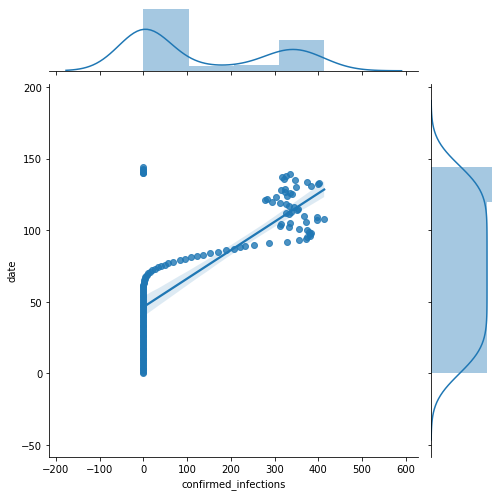

In [64]:
sns.jointplot(x="confirmed_infections", y="pieszo", data=df, kind = 'reg',fit_reg= True, height = 7)
plt.show()

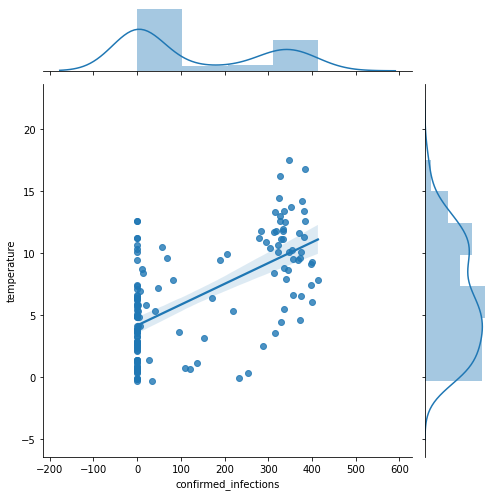

In [47]:
sns.jointplot(x="confirmed_infections", y="temperature", data=df, kind = 'reg',fit_reg= True, height = 7)
plt.show()

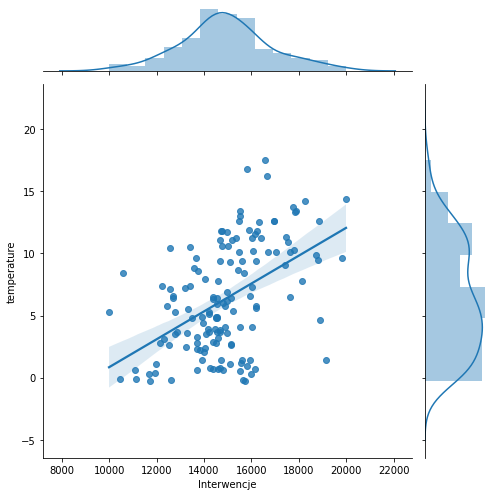

In [52]:
sns.jointplot(x="Interwencje", y="temperature", data=df, kind = 'reg',fit_reg= True, height = 7)
plt.show()

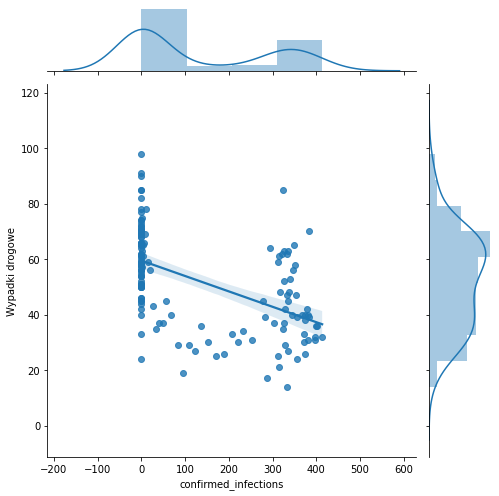

In [53]:
sns.jointplot(x="confirmed_infections", y="Wypadki drogowe", data=df, kind = 'reg',fit_reg= True, height = 7)
plt.show()

In [140]:
kmeans = cluster.MeanShift()
kmeans.fit(df[["confirmed_infections","temperature", "date"]])

MeanShift()

In [141]:
d = pd.DataFrame(df[["confirmed_infections","temperature", "date"]])
d["label"] = pd.Series(kmeans.labels_).values

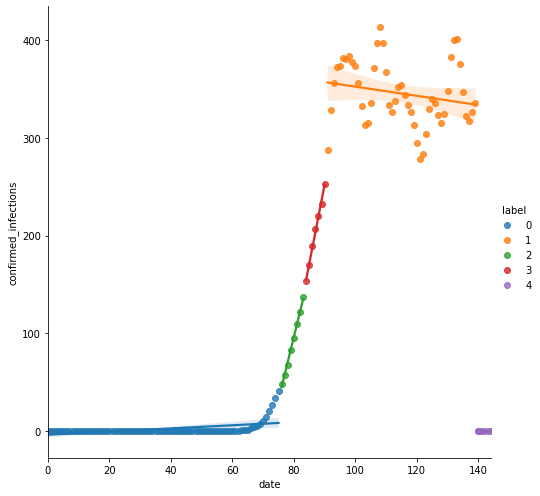

In [142]:
sns.lmplot(x="date", y="confirmed_infections", 
              data=d, fit_reg= True, height = 7, hue = "label")
plt.show()

In [144]:
df.columns

Index(['Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor',
       'date'],
      dtype='object')

In [215]:
y = df["confirmed_infections"]
X = df[["pieszo", "Interwencje", "pojazdem"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
regressor = RandomForestRegressor(random_state=0, max_depth=3, n_estimators=5)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 55.628750800318954
Mean Squared Error: 9086.8551014429
Root Mean Squared Error: 95.32499725383106


In [216]:
pr = pd.DataFrame(X_test)
pr["confirmed_infections"] = y_pred
pr

,pieszo,Interwencje,pojazdem,confirmed_infections
2020-01-08,0.00,14078.0,0.00,0.004149
2020-01-25,0.00,14783.0,0.00,0.004149
2020-01-28,0.00,13930.0,0.00,0.004149
2020-04-29,-58.78,14973.0,-36.56,281.206473
2020-05-21,-39.59,16706.0,-22.81,249.131934
2020-02-21,0.00,15141.0,0.00,0.004149
2020-02-13,0.00,14379.0,0.00,0.004149
2020-01-23,0.00,14368.0,0.00,0.004149
2020-04-22,-59.13,15465.0,-44.89,281.206473
2020-01-27,0.00,14250.0,0.00,0.004149


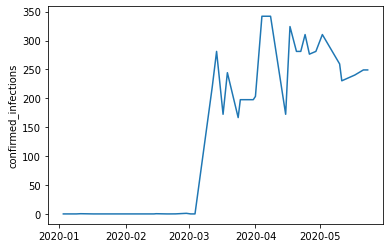

In [217]:
sns.lineplot(x=pr.index, y="confirmed_infections", 
              data=pr)
plt.show()